# Interoperability with numpy arrays

The by far most commen data interface in the Python world are numpy arrays. Therefore, it's crucial for PyROOT to provide interoperability features between the wrapped C++ objects and numpy arrays, which allows to feed data seemlessly from C++ to Python and back.

In [1]:
import ROOT
import numpy as np

Welcome to JupyROOT 6.22/02


## From C++ containers to numpy

PyROOT attachs the [array interface](https://numpy.org/doc/stable/reference/arrays.interface.html) of numpy to suitable C++ containers and therefore allows the adoption of the memory with numpy arrays.

In [2]:
v1 = ROOT.std.vector['float']((1, 2, 3))
print("ROOT.std.vector['float']", v1)

v2 = np.asarray(v1)
print('numpy.array', v2)

v1[0] = 42
print('numpy.array', v2)

ROOT.std.vector['float'] { 1.00000f, 2.00000f, 3.00000f }
numpy.array [1. 2. 3.]
numpy.array [42.  2.  3.]


## From numpy arrays to C++

PyROOT also supports due to [`ROOT::RVec`](https://root.cern/doc/master/classROOT_1_1VecOps_1_1RVec.html) the adoption of memory from objects with a numpy [array interface](https://numpy.org/doc/stable/reference/arrays.interface.html).

In [3]:
v1 = np.array((1, 2, 3), dtype=np.float32)
print('numpy.array', v1)

v2 = ROOT.VecOps.AsRVec(v1)
print("ROOT.RVec['float']", v2)

v1[0] = 42
print("ROOT.RVec['float']", v2)

numpy.array [1. 2. 3.]
ROOT.RVec['float'] { 1.00000f, 2.00000f, 3.00000f }
ROOT.RVec['float'] { 42.0000f, 2.00000f, 3.00000f }


In addition, C++ interfaces with raw pointers are understood natively.

In [4]:
ROOT.gInterpreter.Declare('''
float get_element(float* v, unsigned int i) {
    return v[i];
}
''')

print('The first element of the numpy.array is', ROOT.get_element(v1, 0))

The first element of the numpy.array is 42.0


## Data in ROOT files to numpy

Another crucial feature for Python based analysis is moving data from ROOT files to numpy arrays. To do so, PyROOT offers extensions to [`ROOT::RDataFrame`](https://root.cern/doc/master/classROOT_1_1RDataFrame.html), which allow to load data in [`TTrees`](https://root.cern/doc/master/classTTree.html) as dictionary of numpy arrays. The workflow in mind is doing heavy computation in C++ powered by `RDataFrame` and push only the required data to Python.

In [6]:
path = 'root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root'

df = ROOT.RDataFrame('Events', path)

npy = df.Filter('nMuon == 2')\
        .Filter('Muon_charge[0] != Muon_charge[1]')\
        .Define('Dimuon_mass', 'InvariantMass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)')\
        .Range(10000)\
        .AsNumpy(['Dimuon_mass'])

The result of `AsNumpy` can be directly used to construct a pandas dataframe:

In [7]:
import pandas
pdf = pandas.DataFrame(npy)
print(pdf)

      Dimuon_mass
0       27.915493
1      113.646866
2        1.587861
3       23.723238
4        0.738188
...           ...
9995    24.853788
9996     3.090108
9997    27.981396
9998     0.250488
9999   161.415146

[10000 rows x 1 columns]


Or make a plot with matplotlib:

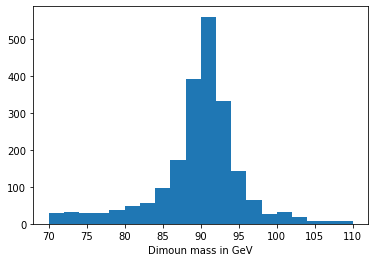

In [8]:
import matplotlib.pyplot as plt
plt.hist(npy['Dimuon_mass'], range=(70, 110), bins=20)
plt.xlabel('Dimoun mass in GeV');

## From numpy arrays to ROOT files

PyROOT supports to create a [`ROOT::RDataFrame`](https://root.cern/doc/master/classROOT_1_1RDataFrame.html) from numpy arrays, which allows to further transform the dataset and eventually write the data back to disk in a ROOT file.

In [9]:
npy2 = {'x': np.array((1, 2, 3), dtype=np.float32), 'y': np.array((4, 5, 6), dtype=np.int32)}

df = ROOT.RDF.MakeNumpyDataFrame(npy2)

display = df.Display()
df.Snapshot('Events', 'file.root')
display.Print()

x        | y | 
1.00000f | 4 | 
2.00000f | 5 | 
3.00000f | 6 | 


We can show with `rootls` the objects in the newly created file:

In [10]:
%%bash
rootls -t file.root

TTree  Sep 23 16:39 2020 Events  "Events"
  x  "x/F"  82
  y  "y/I"  82
  Cluster INCLUSIVE ranges:
   - # 0: [0, 2]
  The total number of clusters is 1
